<a href="https://colab.research.google.com/github/Andressa-Sim/estudos-data-science/blob/main/Pensar_e_Responder_Multinomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
# 1. CRIANDO UM DATASET DE EXEMPLO (Comentários de Clientes)
dados = {
    'texto': [
        # Negativos (Classe 0)
        "O produto quebrou no primeiro dia",
        "Péssima qualidade, não recomendo",
        "Horrível, joguei dinheiro fora",
        "Muito fraco, atendimento ruim",
        "Demorou demais e veio estragado",

        # Neutros (Classe 1)
        "O produto é ok, nada demais",
        "Chegou no prazo, embalagem normal",
        "Cumpre o que promete, mas é básico",
        "Razoável pelo preço pago",
        "Funciona, mas esperava mais",

        # Positivos (Classe 2)
        "Adorei! Maravilhoso, comprarei de novo",
        "Excelente qualidade e entrega rápida",
        "Super recomendo, melhor compra do ano",
        "Fantástico, estou muito feliz",
        "Perfeito, acabamento impecável"
    ],
    'sentimento': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
}

df = pd.DataFrame(dados)

In [5]:
# 2. TRANSFORMANDO TEXTO EM NÚMEROS (Vetorização)
# O CountVectorizer conta quantas vezes cada palavra aparece
vetorizador = CountVectorizer()
X = vetorizador.fit_transform(df['texto']) # Transforma as frases em uma matriz numérica
y = df['sentimento']

In [6]:
# 3. TREINANDO O MODELO MULTINOMIAL
# Usamos o solver 'lbfgs' que lida bem com multiclasse
modelo = LogisticRegression(multi_class='multinomial', solver='lbfgs')
modelo.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial')

In [7]:
# 4. TESTANDO COM NOVAS FRASES (O Momento da Verdade)
# Vamos criar frases que o modelo NUNCA viu antes
novos_comentarios = [
    "O produto é excelente, muito bom mesmo",  # Esperado: Positivo
    "Odiei, veio tudo quebrado e rasgado",     # Esperado: Negativo
    "É um produto básico, chegou na hora",     # Esperado: Neutro
    "A qualidade é horrível"                   # Esperado: Negativo
]

In [11]:
# Precisamos transformar essas novas frases em números usando o MESMO vetorizador do treino
novos_comentarios_vetorizados = vetorizador.transform(novos_comentarios)

# Fazendo a previsão
previsoes = modelo.predict(novos_comentarios_vetorizados)
probs = modelo.predict_proba(novos_comentarios_vetorizados)

mapa_sentimento = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

print("--- ANÁLISE DE NOVOS COMENTÁRIOS ---")
for i, frase in enumerate(novos_comentarios):
    sentimento = mapa_sentimento[previsoes[i]]
    prob_max = max(probs[i]) * 100 # A certeza do modelo
    print(f"Frase: '{frase}'")
    print(f" -> Classificação: {sentimento.upper()} (Certeza: {prob_max:.1f}%)")
    print("-" * 30)

--- ANÁLISE DE NOVOS COMENTÁRIOS ---
Frase: 'O produto é excelente, muito bom mesmo'
 -> Classificação: POSITIVO (Certeza: 40.7%)
------------------------------
Frase: 'Odiei, veio tudo quebrado e rasgado'
 -> Classificação: NEGATIVO (Certeza: 44.3%)
------------------------------
Frase: 'É um produto básico, chegou na hora'
 -> Classificação: NEUTRO (Certeza: 55.2%)
------------------------------
Frase: 'A qualidade é horrível'
 -> Classificação: NEGATIVO (Certeza: 48.2%)
------------------------------


--- PESOS DAS PALAVRAS (Amostra) ---
             Negativo    Neutro  Positivo
acabamento  -0.160005 -0.155495  0.315500
adorei      -0.121514 -0.118331  0.239845
ano         -0.134891 -0.101722  0.236613
atendimento  0.299842 -0.126980 -0.172862
básico      -0.108710  0.219153 -0.110443
chegou      -0.149381  0.269084 -0.119703
compra      -0.134891 -0.101722  0.236613
comprarei   -0.121514 -0.118331  0.239845
cumpre      -0.108710  0.219153 -0.110443
de          -0.121514 -0.118331  0.239845


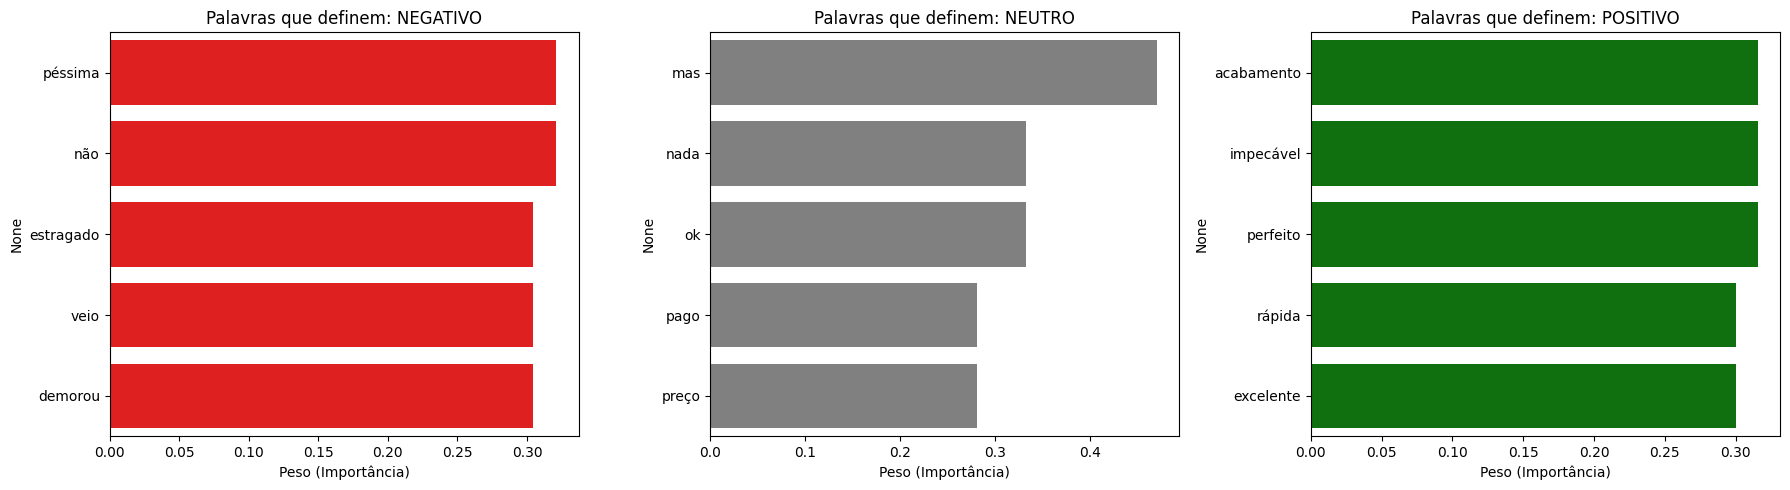

In [10]:
# 1. Pegamos todas as palavras que o modelo aprendeu
palavras = vetorizador.get_feature_names_out()

# 2. Pegamos os pesos (coeficientes) para cada uma das 3 classes
# coef_ tem o formato [3 classes, n_palavras]
pesos = modelo.coef_

# Vamos criar um DataFrame para visualizar melhor
# Cada coluna será uma classe de sentimento
df_coeficientes = pd.DataFrame(pesos.T, columns=['Negativo', 'Neutro', 'Positivo'], index=palavras)

print("--- PESOS DAS PALAVRAS (Amostra) ---")
print(df_coeficientes.head(10)) # Mostra as primeiras 10 palavras em ordem alfabética

# 3. VISUALIZAÇÃO: QUAIS SÃO AS PALAVRAS MAIS IMPORTANTES?
# Vamos fazer um gráfico mostrando as top 3 palavras para cada sentimento

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sentimentos = ['Negativo', 'Neutro', 'Positivo']
cores = ['red', 'gray', 'green']

for i, sentimento in enumerate(sentimentos):
    # Ordenamos para pegar as palavras com maior peso para aquele sentimento
    top_palavras = df_coeficientes[sentimento].sort_values(ascending=False).head(5)

    # Criamos o gráfico de barras
    sns.barplot(x=top_palavras.values, y=top_palavras.index, ax=axes[i], color=cores[i])
    axes[i].set_title(f'Palavras que definem: {sentimento.upper()}')
    axes[i].set_xlabel('Peso (Importância)')

plt.tight_layout()
plt.show()